In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import string 
import re # for regular expressions

import nltk #for text manipulation 
from nltk.stem import PorterStemmer,WordNetLemmatizer
from nltk.corpus import stopwords
stop=stopwords.words('english')
stop.remove('not')

from wordcloud import WordCloud

import seaborn as sns 
import matplotlib.pyplot as plt  

pd.set_option("display.max_colwidth", 200) 
warnings.filterwarnings("ignore", category=DeprecationWarning) 
%matplotlib inline

#from textblob import Word
# from textblob import TextBlob
import gensim
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,f1_score, auc, roc_curve
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

In [2]:
train=pd.read_csv("../../../input/twitters/train_E6oV3lV.csv")
test=pd.read_csv("../../../input/twitters/test_tweets_anuFYb8.csv")
train.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run
1,2,0,@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in urð±!!! ðððð ð¦ð¦ð¦
4,5,0,factsguide: society now #motivation


In [3]:
combine = train.append(test, ignore_index=True, sort=True)
test.shape, train.shape, combine.shape

((17197, 2), (31962, 3), (49159, 3))

In [4]:
print('shape of train dataset',train.shape)
train.label.value_counts()

shape of train dataset (31962, 3)


0    29720
1     2242
Name: label, dtype: int64

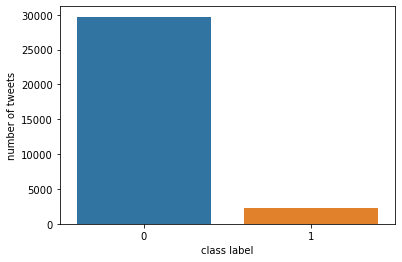

In [5]:
sns.countplot(train.label,)
plt.xlabel('class label')
plt.ylabel('number of tweets')
plt.show()

## 1. Feature Engineering
- the number of word
- the number of characters
- average word length
- count stopwords
- count hashtags
- count numbers
- count upper case

In [6]:
# 1.1 count the word
combine['word_count']=combine['tweet'].apply(lambda x:len(str(x).split(" ")))
combine[['tweet','word_count']].head()

,tweet,word_count
0,@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run,21
1,@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked,22
2,bihday your majesty,5
3,#model i love u take with u all the time in urð±!!! ðððð ð¦ð¦ð¦,17
4,factsguide: society now #motivation,8


In [7]:
# 1.2 count the characters
combine['char_count']=combine['tweet'].str.len()
combine[['tweet','char_count']].head()

,tweet,char_count
0,@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run,102
1,@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked,122
2,bihday your majesty,21
3,#model i love u take with u all the time in urð±!!! ðððð ð¦ð¦ð¦,86
4,factsguide: society now #motivation,39


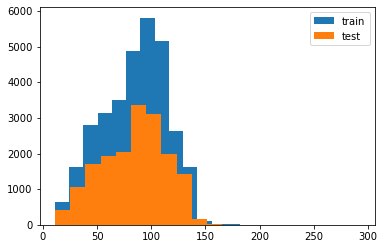

In [8]:
plt.hist(train.tweet.str.len(), bins=20, label='train')
plt.hist(test.tweet.str.len(), bins=20, label='test')
plt.legend()
plt.show()

In [9]:
# 1.3 avegare word length
def avg_word(sentence):
    words=sentence.split()
    return (sum(len(word) for word in words)/len(words))

combine['avg_word']=combine['tweet'].apply(lambda x:avg_word(x))
combine[['tweet','avg_word']].head()

,tweet,avg_word
0,@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run,4.555556
1,@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked,5.315789
2,bihday your majesty,5.666667
3,#model i love u take with u all the time in urð±!!! ðððð ð¦ð¦ð¦,4.928571
4,factsguide: society now #motivation,8.000000


In [10]:
# 1.4 count stopwords
combine['stopwords']=combine['tweet'].apply(lambda sen:len([x for x in sen.split() if x in stop]))
combine[['tweet','stopwords']].head()

,tweet,stopwords
0,@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run,10
1,@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked,5
2,bihday your majesty,1
3,#model i love u take with u all the time in urð±!!! ðððð ð¦ð¦ð¦,5
4,factsguide: society now #motivation,1


In [11]:
# 1.5 count hasgtags
combine['hashtags']=combine['tweet'].apply(lambda sen:len([x for x in sen.split() if x.startswith("#")]))
combine[['tweet','hashtags']].head()

,tweet,hashtags
0,@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run,1
1,@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked,3
2,bihday your majesty,0
3,#model i love u take with u all the time in urð±!!! ðððð ð¦ð¦ð¦,1
4,factsguide: society now #motivation,1


In [12]:
# 1.6 count numeric
combine['numerics']=combine['tweet'].apply(lambda sen:len([x for x in sen.split() if x.isdigit()]))
combine[['tweet','numerics']].head()

,tweet,numerics
0,@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run,0
1,@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked,0
2,bihday your majesty,0
3,#model i love u take with u all the time in urð±!!! ðððð ð¦ð¦ð¦,0
4,factsguide: society now #motivation,0


In [13]:
# 1.7 count upper case
combine['upper']=combine['tweet'].apply(lambda sen:len([x for x in sen.split() if x.isupper()]))
combine[['tweet','upper']].head()

,tweet,upper
0,@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run,0
1,@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked,0
2,bihday your majesty,0
3,#model i love u take with u all the time in urð±!!! ðððð ð¦ð¦ð¦,0
4,factsguide: society now #motivation,0


## 2. Text Preprocessing
- convert to lower case 
- Twitter Handles (@user)
- urls
- punctuations & numbers & Special Characters
- short words that len <= 3 (not applied)
- stop words 
- remove the top10 and bottom 10 frequent word (not applied)
- spelling correction (not applied)
- normalize - stem and lemma

In [14]:
%%time
# convert to lower case - necessary??
combine['tidy_tweet']=combine['tweet'].apply(lambda sen:" ".join(x.lower() for x in sen.split()))

# remove Twitter Handles (@user)
combine['tidy_tweet'] = combine['tidy_tweet'].str.replace(r'@[\w]*','')

# remove url
combine['tidy_tweet'] = combine['tidy_tweet'].str.replace(r'http/S+','')

# remove punctuations & numbers & Special Characters
combine['tidy_tweet'] = combine['tidy_tweet'].str.replace("[^a-zA-Z#]", " ") # str.replace('[^\w\s]','')

# remove words if len(words) <= 3
# combine['tidy_tweet'] = combine['tidy_tweet'].apply(lambda x: ' '.join([w for w in x.split() if len(w) > 3]))

# remove stop words  
combine['tidy_tweet']=combine['tidy_tweet'].apply(lambda sen:" ".join(x for x in sen.split() if x not in stop))

# stemming and lemmatization
st=PorterStemmer()
wordnet=WordNetLemmatizer()
tokenized_tweet = combine.tidy_tweet.apply(lambda x: x.split())
tokenized_tweet = tokenized_tweet.apply(lambda x: [st.stem(i) for i in x]) # stemming
tokenized_tweet = tokenized_tweet.apply(lambda x: [wordnet.lemmatize(i) for i in x]) # stemming
for i in range(len(tokenized_tweet)):
    tokenized_tweet[i] = ' '.join(tokenized_tweet[i]) 
    
combine['tidy_tweet'] = tokenized_tweet
combine.head(2)

CPU times: user 24.3 s, sys: 217 ms, total: 24.5 s
Wall time: 28.6 s


,id,label,tweet,word_count,char_count,avg_word,stopwords,hashtags,numerics,upper,tidy_tweet
0,1,0.0,@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run,21,102,4.555556,10,1,0,0,father dysfunct selfish drag kid dysfunct #run
1,2,0.0,@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked,22,122,5.315789,5,3,0,0,thank #lyft credit use caus offer wheelchair van pdx #disapoint #getthank


In [15]:
cols = [x for x in combine.columns if x not in ['tweet', 'preprocess_tweet']]
Train = combine[:len(train)][cols]
Test = combine[len(train):][cols].reset_index(drop=True)

## 3. Text visulization

- Understanding the common words used in the tweets: WordCloud
- Words in positive label and negative label
- Understanding the impact of Hashtags on tweets sentiment

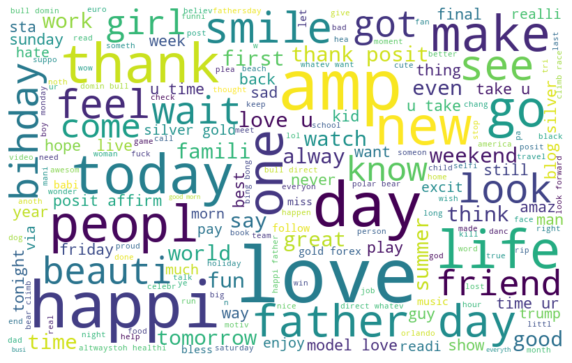

In [16]:
all_words = ' '.join([text for text in combine['tidy_tweet']]) 
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110, background_color='white').generate(all_words) 
plt.figure(figsize=(10, 7)) 
plt.imshow(wordcloud, interpolation="bilinear") 
plt.axis('off')
plt.show()

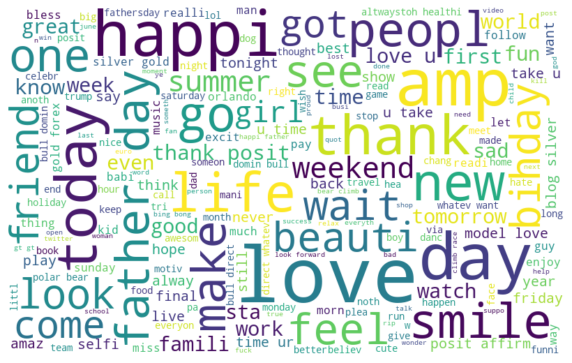

In [17]:
normal_words =' '.join([text for text in combine['tidy_tweet'][combine['label'] == 0]]) 
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110, background_color='white').generate(normal_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

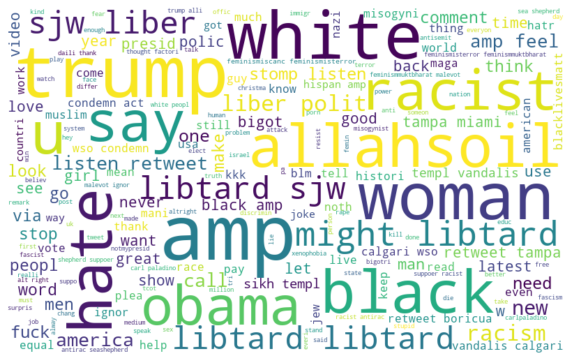

In [18]:
negative_words = ' '.join([text for text in combine['tidy_tweet'][combine['label'] == 1]])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110, background_color='white').generate(negative_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

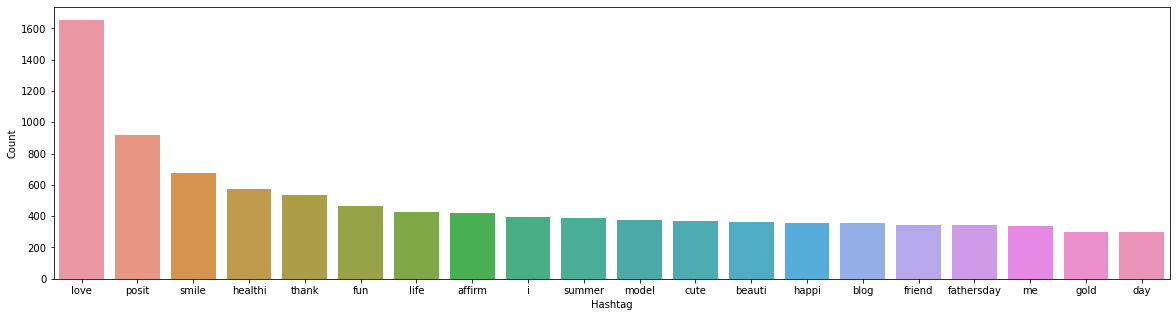

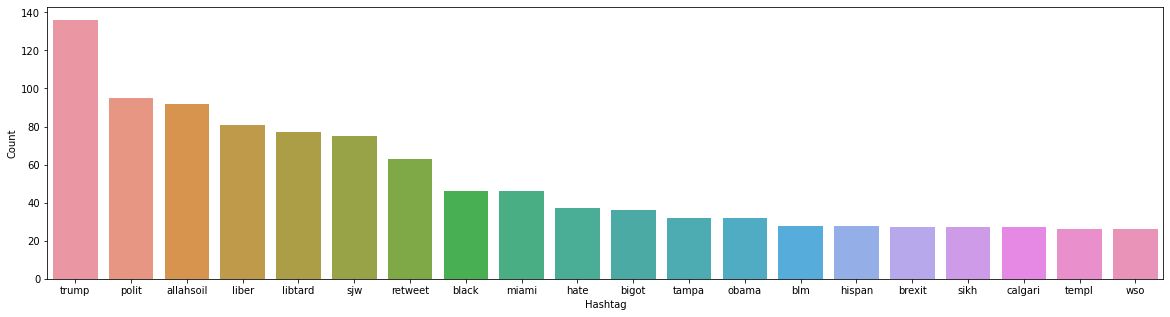

In [19]:
# function to collect hashtags 
def hashtag_extract(x):
    hashtags = []    # Loop over the words in the tweet
    for i in x:
        ht = re.findall(r"#(\w+)", i)
        hashtags.append(ht)
    return hashtags

# extracting hashtags from label = 0
HT_regular = hashtag_extract(combine['tidy_tweet'][combine['label'] == 0]) 

# extracting hashtags from label = 1
HT_negative = hashtag_extract(combine['tidy_tweet'][combine['label'] == 1]) 

# unnesting list
HT_regular = sum(HT_regular,[]) 
HT_negative = sum(HT_negative,[])

# label = 0
a = nltk.FreqDist(HT_regular)
d = pd.DataFrame(
    {
    'Hashtag': list(a.keys()),
    'Count': list(a.values())
    }
) 
# selecting top 20 most frequent hashtags
d = d.nlargest(columns="Count", n = 20)
plt.figure(figsize=(20,5))
ax = sns.barplot(data=d, x= "Hashtag", y = "Count")
ax.set(ylabel = 'Count')
# plt.xticks(rotation=90)
plt.show()

# label = 1
a = nltk.FreqDist(HT_negative)
d = pd.DataFrame(
    {
    'Hashtag': list(a.keys()),
    'Count': list(a.values())
    }
) 

# selecting top 20 most frequent hashtags
d = d.nlargest(columns="Count", n = 20)
plt.figure(figsize=(20,5))
ax = sns.barplot(data=d, x= "Hashtag", y = "Count")
ax.set(ylabel = 'Count')
# plt.xticks(rotation=90)
plt.show()

## 4. Text Processing

#### 4.1 Bag of words

In [20]:
bow = CountVectorizer(min_df=2, max_features=1000,lowercase=True, ngram_range=(1,1),analyzer = "word")
bow.fit(Train['tidy_tweet'])
bow_df = bow.transform(Train['tidy_tweet']).toarray()
print('Feature name == ',bow.get_feature_names()[:10])
print('Number of uniqe words', bow_df.shape[1])
print('Shape', bow_df.shape)
bow_train = pd.DataFrame(bow_df)

Feature name ==  ['abl', 'absolut', 'accept', 'account', 'act', 'action', 'actor', 'actual', 'ad', 'adapt']
Number of uniqe words 1000
Shape (31962, 1000)


In [21]:
cols = [x for x in combine.columns if x not in ['id', 'tweet', 'tidy_tweet', 'label']] + ['label']
bow_train[cols]=Train[cols]
bow_train.head()

,0,1,2,3,4,5,6,7,8,9,...,998,999,word_count,char_count,avg_word,stopwords,hashtags,numerics,upper,label
0,0,0,0,0,0,0,0,0,0,0,...,0,0,21,102,4.555556,10,1,0,0,0.0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,22,122,5.315789,5,3,0,0,0.0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,5,21,5.666667,1,0,0,0,0.0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,17,86,4.928571,5,1,0,0,0.0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,8,39,8.000000,1,1,0,0,0.0


#### 4.2 TF-IDF

- Term frequency
  - TF = (Number of times term T appears in the particular row) / (number of terms in that row)
  
- Inverse Document Frequency
  - DF = log(N/n)

In [22]:
tfidf = TfidfVectorizer(ngram_range=(1, 2),min_df=2,max_features=1000, lowercase=True, analyzer='word',stop_words= 'english')
tfidf.fit(Train['tidy_tweet'])
tfidf_df=tfidf.transform(Train['tidy_tweet']).toarray()
print('Number of uniqe words',tfidf_df.shape[1])
print('Shape',tfidf_df.shape)
tfidf_train=pd.DataFrame(tfidf_df)
cols = [x for x in combine.columns if x not in ['id', 'tweet', 'tidy_tweet', 'label']] + ['label']
tfidf_train[cols]=Train[cols]
tfidf_train.head()

Number of uniqe words 1000
Shape (31962, 1000)


,0,1,2,3,4,5,6,7,8,9,...,998,999,word_count,char_count,avg_word,stopwords,hashtags,numerics,upper,label
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,21,102,4.555556,10,1,0,0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,22,122,5.315789,5,3,0,0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,5,21,5.666667,1,0,0,0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,17,86,4.928571,5,1,0,0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,8,39,8.000000,1,1,0,0,0.0


#### 4.3 Word embedding
**Word2vec** - 文本的向量化表示，相似单词的向量之间的距离比较短。

- size: The number of dimensions of the embeddings and the default is 100.

- window: The maximum distance between a target word and words around the target word. The default window is 5.

- min_count: The minimum count of words to consider when training the model; words with occurrence less than this count will be ignored. The default for min_count is 5.

- workers: The number of partitions during training and the default workers is 3.

- sg: The training algorithm, either CBOW(0) or skip gram(1). The default training algorithm is CBOW.

In [23]:
%%time
tokenize = Train['tidy_tweet'].apply(lambda x: x.split())
w2vec_model = gensim.models.Word2Vec(
    tokenize,
    min_count = 1, 
    size = 100, 
    window = 5, 
    sg = 1,
    hs = 0,
    seed = 34)
w2vec_model.train(tokenize,total_examples= len(combine['tidy_tweet']),epochs=20)

CPU times: user 1min 1s, sys: 548 ms, total: 1min 1s
Wall time: 33.3 s


(4813887, 5011220)

In [24]:
w2vec_model.wv.most_similar(positive="father")

[('#fathersday', 0.7552626132965088),
 ('#father', 0.751185417175293),
 ('dad', 0.7438942193984985),
 ('#dad', 0.7230821251869202),
 ('fathersday', 0.7065808773040771),
 ('#daddi', 0.69353187084198),
 ('papa', 0.6928750276565552),
 ('#clapton', 0.6821501851081848),
 ('#hackneywick', 0.6689520478248596),
 ('daddi', 0.6686502695083618)]

In [25]:
w2v_words = list(w2vec_model.wv.vocab)
print("Number of words that occured minimum 5 times ",len(w2v_words))
print("Sample words ", w2v_words[0:10])

Number of words that occured minimum 5 times  36842
Sample words  ['father', 'dysfunct', 'selfish', 'drag', 'kid', '#run', 'thank', '#lyft', 'credit', 'use']


In [26]:
# create a vector for each tweet by taking the average of the vectors of the words present in the tweet.
# Preparing word2vec feature set…
vector=[]
from tqdm import tqdm
for sent in tqdm(tokenize):
    sent_vec=np.zeros(100)
    count =0
    for word in sent: 
        if word in w2v_words:
            vec = w2vec_model.wv[word]
            sent_vec += vec 
            count += 1
    if count != 0:
        sent_vec /= count #normalize
    vector.append(sent_vec)
print(len(vector))
print(len(vector[0]))        

100%|██████████| 31962/31962 [00:42<00:00, 745.89it/s]

31962
100


In [27]:
print('Number of uniqe words',len(vector[1]))
w2v_train=pd.DataFrame(vector)
cols = [x for x in combine.columns if x not in ['id', 'tweet', 'tidy_tweet', 'label']] + ['label']
w2v_train[cols]=Train[cols]
w2v_train.head()

Number of uniqe words 100


,0,1,2,3,4,5,6,7,8,9,...,98,99,word_count,char_count,avg_word,stopwords,hashtags,numerics,upper,label
0,-0.372434,-0.173622,0.246087,0.352524,-0.025100,0.235855,-0.247293,-0.240673,-0.118388,-0.088296,...,0.322465,-0.133764,21,102,4.555556,10,1,0,0,0.0
1,-0.046925,-0.338783,0.302392,0.153537,0.131234,0.294648,-0.067651,-0.086164,-0.236452,-0.115274,...,-0.269472,-0.025676,22,122,5.315789,5,3,0,0,0.0
2,-0.283884,0.390661,0.195085,0.567141,-0.051129,-0.575507,0.173938,0.049705,-0.756192,0.152141,...,-0.644777,-0.342367,5,21,5.666667,1,0,0,0,0.0
3,-0.720474,-0.176704,-0.411516,0.327580,0.115764,0.555771,-0.173481,0.455337,0.057227,-0.072840,...,0.376555,-0.072953,17,86,4.928571,5,1,0,0,0.0
4,-0.381396,0.227982,-0.104560,0.311589,-0.070256,0.626613,-0.135649,-0.371533,-0.483606,-0.107883,...,-0.118309,-0.481907,8,39,8.000000,1,1,0,0,0.0


## 5. Split data

In [28]:
x = bow_train.iloc[:,0:-1]
y = bow_train['label']
x_train_bow, x_val_bow, y_train_bow, y_val_bow = train_test_split(x,y,test_size=0.2)

In [29]:
x=tfidf_train.iloc[:,0:-1]
y=tfidf_train['label']
x_train_tfidf, x_val_tfidf, y_train_tfidf, y_val_tfidf = train_test_split(x,y,test_size=0.2)

In [30]:
x = w2v_train.iloc[:,0:-1] 
y = w2v_train['label']
x_train_w2v,x_val_w2v,y_train_w2v,y_val_w2v = train_test_split(x,y,test_size=0.2)

## 6. Model selection

In [31]:
def f1_score_(y_proba,y_test):
    proba = y_proba[:,1] >= 0.3
    proba = proba.astype(np.int) 
    return f1_score( proba,y_test)  

#### KNN + BOW

In [32]:
k=[3,5,7]
accuracy=[]
for i in tqdm(k):
    model=KNeighborsClassifier(n_neighbors=i)
    model.fit(x_train_bow,y_train_bow)
    y_pred=model.predict(x_val_bow)
    acc=accuracy_score(y_pred,y_val_bow)
    print('for k=',i,'Accuracy Score',acc)
    accuracy.append(acc)
    y_proba=model.predict_proba(x_val_bow)
    f1_scor=f1_score_(y_proba,y_val_bow)
    print('for k=',i,'f1 score ',f1_scor)

  0%|          | 0/3 [00:00<?, ?it/s]

for k= 3 Accuracy Score 0.9206945096198967


 33%|███▎      | 1/3 [00:34<01:08, 34.35s/it]

for k= 3 f1 score  0.27146814404432135
for k= 5 Accuracy Score 0.9292976693258251


 67%|██████▋   | 2/3 [01:09<00:34, 34.45s/it]

for k= 5 f1 score  0.29702970297029707
for k= 7 Accuracy Score 0.9328953542937588


100%|██████████| 3/3 [01:46<00:00, 35.44s/it]

for k= 7 f1 score  0.3072847682119205


#### KNN + TFIDF

In [33]:
k=[3,5,11]
accuracy_tfidf=[]
for i in k:
    model=KNeighborsClassifier(n_neighbors=i)
    model.fit(x_train_tfidf,y_train_tfidf)
    y_pred=model.predict(x_val_tfidf)
    acc=accuracy_score(y_pred,y_val_tfidf)
    print('for k=',i,'Accuracy Score',acc)
    accuracy_tfidf.append(acc)
    y_proba=model.predict_proba(x_val_tfidf)
    f1_scor=f1_score_(y_proba,y_val_tfidf)
    print('for k=',i,'f1 score ',f1_scor)

for k= 3 Accuracy Score 0.9250743000156421
for k= 3 f1 score  0.26943699731903487
for k= 5 Accuracy Score 0.9267949319568278
for k= 5 f1 score  0.2577447335811648
for k= 11 Accuracy Score 0.9277334584702018
for k= 11 f1 score  0.20364741641337386


#### KNN + Word2Vec

In [34]:
k=[3,5,11]
accuracy_w2v=[]
for i in tqdm(k):
    model=KNeighborsClassifier(n_neighbors=i)
    model.fit(x_train_w2v,y_train_w2v)
    y_pred=model.predict(x_val_w2v)
    acc=accuracy_score(y_pred,y_val_w2v)
    print('for k=',i,'Accuracy Score',acc)
    accuracy_w2v.append(acc)
    y_proba=model.predict_proba(x_val_w2v)
    f1_scor=f1_score_(y_proba,y_val_w2v)
    print('for k=',i,'f1 score ',f1_scor)

  0%|          | 0/3 [00:00<?, ?it/s]

for k= 3 Accuracy Score 0.9332081964648835


 33%|███▎      | 1/3 [00:04<00:08,  4.49s/it]

for k= 3 f1 score  0.3676056338028169
for k= 5 Accuracy Score 0.9383700922884405


 67%|██████▋   | 2/3 [00:10<00:04,  4.90s/it]

for k= 5 f1 score  0.421301775147929
for k= 11 Accuracy Score 0.9374315657750665


100%|██████████| 3/3 [00:15<00:00,  5.22s/it]

for k= 11 f1 score  0.408695652173913


#### XGB + word2vec

In [36]:
%%time
xgb = XGBClassifier(max_depth=6, n_estimators=1000, nthread= 3).fit(x_train_w2v, y_train_w2v) 
prediction = xgb.predict(x_val_w2v)
print('F1 score: ', f1_score(y_val_w2v, prediction))
print('Accuracy score: ', accuracy_score(y_val_w2v, prediction))
fpr, tpr, _ = roc_curve(y_val_w2v, prediction)
print('AUC: ', auc(fpr, tpr))

F1 score:  0.6931216931216931
Accuracy score:  0.9637103081495385
AUC:  0.7868473215958255
CPU times: user 6min 41s, sys: 1.95 s, total: 6min 43s
Wall time: 3min 46s
